Logistic Regression (Balanced) — Classification Report
              precision    recall  f1-score   support

           0       0.99      0.70      0.82      1388
           1       0.13      0.84      0.22        73

    accuracy                           0.71      1461
   macro avg       0.56      0.77      0.52      1461
weighted avg       0.94      0.71      0.79      1461



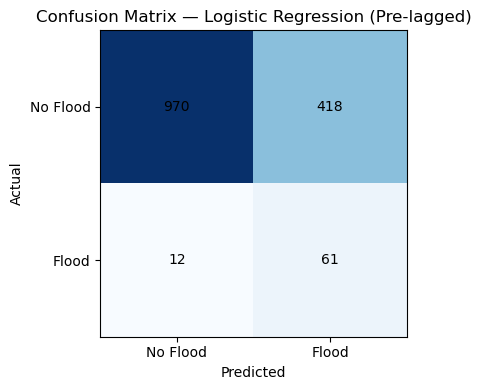

ROC-AUC (LR pre-lag): 0.826


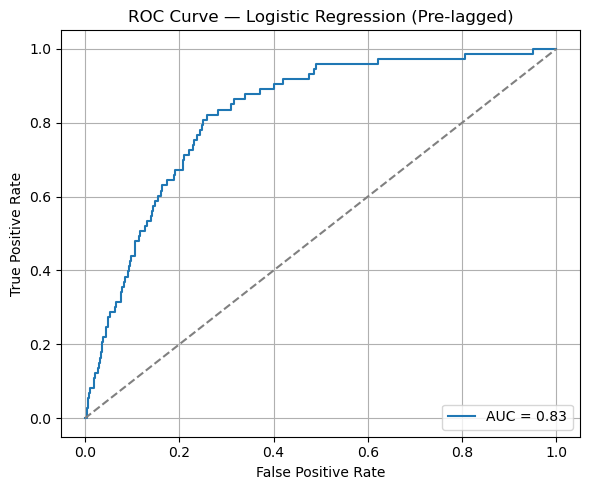

CV F1 (LR pre-lag): [0.21694915 0.1969697  0.19895288 0.15195072 0.23613596] Mean: 0.20019168096904857


In [1]:
# logistic_regression_prelag.py
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import joblib

#  Loading the data before lagged  ----------
df = pd.read_csv("flood_model_labeled.csv")  


features = [
    "tmin", "tmax",
    "soil_temp_5cm", "soil_temp_10cm", "soil_temp_20cm", "soil_temp_50cm",
    "soil_moisture_0_5cm", "rainfall"
]
X = df[features].copy()
y = df["flood"].astype(int).copy()

# ---------Train, test split -----------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)

#  class_weight='balanced'-------
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("lr", LogisticRegression(
        class_weight="balanced",
        penalty="l2",
        solver="liblinear",   
        max_iter=2000,
        random_state=42
    ))
])


pipe.fit(X_train, y_train)


y_pred = pipe.predict(X_test)
y_proba = pipe.predict_proba(X_test)[:, 1]


print("Logistic Regression (Balanced) — Classification Report")
print(classification_report(y_test, y_pred, digits=2))


cm = confusion_matrix(y_test, y_pred, labels=[0,1])
plt.figure(figsize=(5,4))
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix — Logistic Regression (Pre-lagged)")
plt.xticks([0,1], ["No Flood","Flood"])
plt.yticks([0,1], ["No Flood","Flood"])
for (i,j), v in np.ndenumerate(cm):
    plt.text(j, i, str(v), ha="center", va="center")
plt.xlabel("Predicted"); plt.ylabel("Actual")
plt.tight_layout(); plt.show()


fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
print(f"ROC-AUC (LR pre-lag): {roc_auc:.3f}")

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0,1],[0,1],"--",color="gray")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curve — Logistic Regression (Pre-lagged)")
plt.legend(loc="lower right"); plt.grid(True)
plt.tight_layout(); plt.show()


cv_scores = cross_val_score(pipe, X, y, cv=5, scoring="f1")
print("CV F1 (LR pre-lag):", cv_scores, "Mean:", cv_scores.mean())


joblib.dump(pipe, "logreg_prelag_model.pkl")
print("Saved: logreg_prelag_model.pkl")
